# Auxiliary Notebook: Ramping cell analysis

Determination of ramping status for individual astrocytes.

---

## Setup

#### Imports

In [94]:
# Others

from pathlib import Path

from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
import statsmodels.api as sm

# Internal

from uncaging import (
    Helper,
)

import uncaging.utils as uutils

import aqua.stats as astats

#### Parameters

In [95]:
params_path = Path( 'config' ) / 'net_astro-ramping.yaml'
params = uutils.load_params( params_path )

# See `config/common/net_astro-experiments.yaml` for available options
experiment = 'GABA'
params['experiment'] = experiment
# See `config/net_astro-exvivo.yaml` for how to set this up
analysis = 'gaba'
params['analysis'] = analysis

In [96]:
helper = Helper(
    config_path = params['helper_configs'],
    hive_root = params['hive_root'],
    output_to = params['output_parent'],
)

# TODO This is a kludge because of how complicated the config loading ended
# up being
helper._config['postprocessing']['exclude_ramp'] = False

# For reproducible results with randomness
np.random.seed( params['random_seed'] )

# Output saving
notebook_stem = params['notebook_stem']

save_figure = helper.figure_saver( notebook_stem, experiment )
save_data = helper.data_saver( notebook_stem, experiment )
save_csv = helper.csv_saver( notebook_stem, experiment )

---

## Load data

In [97]:
events_analyze = helper.load_analysis_events(
    params['analysis'],
    extra_decorators = [],
    verbose = True,
)

Loading 20200810_CytoGp31m_S1_RuBiGABA3_10stim-011Cycle00001_Ch1_cell-events.mat...:   5%|▌         | 3/56 [00:00<00:02, 23.23it/s]

Loading 20200814_CytoGp35m_S2_RuBiGlu4_10stims-024Cycle00001_Ch1_cell-events.mat...: 100%|██████████| 56/56 [00:01<00:00, 28.20it/s] 


---

## Helpers

#### TODO Look for overlap in subsequent updates to the `uncaging` module

### Analysis

In [98]:
# TODO Slow
def bin_events( events, bin_edges,
                bin_key = 'start_time_rel' ):
    """Determines the number of events in each bin"""
    
    bin_lefts = bin_edges[:-1]
    bin_rights = bin_edges[1:]
    n_bins = len( bin_lefts )
    
    ret_array = np.zeros( (n_bins, 4) )
    
    for i_bin, (bin_left, bin_right) in enumerate( zip( bin_lefts, bin_rights ) ):
        filter_cur = (events[bin_key] >= bin_left) & (events[bin_key] < bin_right)
        ret_array[i_bin, 0] = bin_left
        ret_array[i_bin, 1] = bin_right
        ret_array[i_bin, 2] = (bin_left + bin_right) * 0.5
        ret_array[i_bin, 3] = np.sum( filter_cur )
    
    ret = pd.DataFrame( ret_array,
                        columns = ['t_left', 't_right', 't_center', 'count'] )
    ret['count'] = ret['count'].astype( int )
    
    return ret

def ramp_effect( events, baseline_window,
                 min_events = 3,
                 bin_key = 'start_time_rel',
                 bins = None ):
    """Determines the effect of time on event rate in `baseline_window` using Poisson GLM regression"""
    
    if bins is None:
        # Default is 1s bins
        bins = np.arange( baseline_window[0], baseline_window[1] + 1, 1 )
    
    ret = dict()
    
    ret['p'] = np.nan
    ret['ramp_magnitude_absolute'] = np.nan
    ret['n_events'] = np.nan
    
    filter_baseline = (events[bin_key] >= baseline_window[0]) & (events[bin_key] < baseline_window[1])
    events_baseline = events[filter_baseline]
    
    ret['n_events'] = len( events_baseline )
    if ret['n_events'] < min_events:
        # Not enough events to determine ramping
        return ret
    
    counts_baseline = bin_events( events_baseline, bins,
                                  bin_key = bin_key )
    
    formula = 'count ~ t_center'
    model = smf.glm( formula,
                     data = counts_baseline,
                     family = sm.families.Poisson() )
    results = model.fit()
    
    ret['p'] = results.pvalues['t_center']
    ret['ramp_magnitude_absolute'] = results.params['t_center']
    
    return ret

def group_ramp_effects( events, baseline_window,
                        bin_key = 'start_time_rel',
                        bins = None,
                        group_key = 'cell_global',
                        keep_keys = [],
                        verbose = False ):
    """Returns a `DataFrame` with the ramp effect information for each group, specified by `group_key`"""
    
    it = events.groupby( group_key )
    if verbose:
        it = tqdm( it )
    
    ret = pd.DataFrame()
    
    for group, group_events in it:
        ramp_spec = ramp_effect( group_events, baseline_window,
                                 bin_key = bin_key,
                                 bins = bins )
        ramp_spec[group_key] = group
        for k in keep_keys:
            ramp_spec[k] = group_events.iloc[0][k]
        # ret = ret.append( ramp_spec, ignore_index = True )
        ret_cur = pd.DataFrame( ramp_spec, index = [0] )
        ret = pd.concat( [ret, ret_cur], ignore_index = True )
    
    ret[group_key] = ret[group_key].astype( int )
    ret['n_events'] = ret['n_events'].astype( int )
    
    return ret

def reformat_ramp_effects( df_ramp,
                           p_thresh = 0.05 ):
    """Apply some expected reformatting for the ramp effects output"""
    
    ret = df_ramp.copy()
    
    # Relabel 'cell' column to 'cell_recording'
    ret['cell_recording'] = ret['cell']
    ret = ret.drop( columns = ['cell'] )
    
    # Change data type for cell columns
    # The coreg column isn't needed downstream, and some of this postprocessing
    # changed in the re-working of the `uncagin` module later
    # ret['cell_coreg'] = ret['cell_coreg'].astype( int )
    ret['cell_recording'] = ret['cell_recording'].astype( int )
    
    # Provide binary ramping keys
    ret['+_ramping'] = False
    filter_pos_ramping = (ret['p'] < p_thresh) & (ret['ramp_magnitude_absolute'] > 0)
    ret.loc[filter_pos_ramping, '+_ramping'] = True
    
    ret['-_ramping'] = False
    filter_neg_ramping = (ret['p'] < p_thresh) & (ret['ramp_magnitude_absolute'] < 0)
    ret.loc[filter_neg_ramping, '-_ramping'] = True
    
    return ret

def eval_rate( events, t_eval,
               baseline_window = None,
               key = 'start_time_rel',
               **kwargs ):
    """Evaluate the kernel rate estimate for the given events
    
    If `baseline_window` is specified, normalize to the baseline period
    """
    
    rf = astats.RateFunctionKernel( **kwargs )
    rf.fit( events[key] )
    
    r_eval = rf.predict( t_eval )
    
    if baseline_window is None:
        return r_eval
    
    rf_constant = astats.RateFunctionConstant( baseline_window )
    rf_constant.fit( events[key] )
    
    r_eval_baseline = rf_constant.predict( t_eval )
    
    return r_eval / r_eval_baseline

### Plotting

In [99]:
def raster_plot_usable( data, t,
                        baseline_window = None,
                        height = 8,
                        title = None,
                        output = None ):
    """TODO Description"""
    
    filter_usable = np.sum( np.isinf( data ) | np.isnan( data ), axis = 1 ) == 0
    data_usable = data[filter_usable, :]

    filter_post = t >= 0
    sort_order = np.argsort( np.trapz( data_usable[:, filter_post], axis = 1 ) )

    plt.figure( figsize = (12, height) )
    plt.imshow( data_usable[sort_order, :],
                extent = [t[0], t[-1], 0, data.shape[0]],
                aspect = 'auto',
                interpolation = 'none',
                cmap = 'Spectral_r' )
    plt.clim( 0, 4 )

    if baseline_window is not None:
        yl = plt.ylim()
        plt.plot( baseline_window[0] * np.array( [1, 1] ),
                  yl,
                  'w--',
                  linewidth = 2 )
        plt.plot( baseline_window[1] * np.array( [1, 1] ),
                  yl,
                  'w--',
                  linewidth = 2 )

    if title is not None:
        plt.title( title, fontsize = 16 )
    
    if output is None:
        plt.show()
    else:
        plt.savefig( output )
    
def trace_plot_usable( data, t,
                       kernel_width = None,
                       baseline_window = None,
                       title = None,
                       output = None ):
    """TODO Description"""
    
    filter_usable = np.sum( np.isinf( data ) | np.isnan( data ), axis = 1 ) == 0
    data_usable = data[filter_usable, :]
    
    data_usable_mean = np.mean( data_usable, axis = 0 )
    data_usable_err = (3. / np.sqrt( data_usable_mean.shape[0] )) * np.std( data_usable, axis = 0 )

    plt.figure( figsize = (12, 4) )
    plt.plot( t, data_usable_mean, 'k-' )
    plt.fill_between( t,
                      data_usable_mean - data_usable_err,
                      data_usable_mean + data_usable_err,
                      color = 'k',
                      alpha = 0.2 )
    xl = plt.xlim()
    plt.plot( xl, [1, 1], 'k--' )
    yl = plt.ylim()
    
    if kernel_width is not None:
        plt.plot( [-kernel_width, -kernel_width], yl, 'g--' )

    plt.xlim( xl )
    plt.ylim( yl )

    if title is not None:
        plt.title( title, fontsize = 16 )
    
    if output is None:
        plt.show()
    else:
        plt.savefig( output )

---

## Run

### Cache params

In [100]:
group_key = params['group_key']

ramp_window = params['ramp_window']
ramp_bin_width = params['ramp_bin_width']
ramp_model_bins = np.arange(
    ramp_window[0],
    ramp_window[1] + ramp_bin_width,
    ramp_bin_width
)

p_thresh_ramp = params['p_thresh_ramp']

# These are what is needed by the analysis
keep_keys = [
    # 'cell_coreg', # See above
    'cell',
    'condition',
    'filename'
]
params['keep_keys'] = keep_keys

#### TODO
The original script had this all multiplexed over multiple `experiments`; here it's run one at a time, but it would be nice to return that functionality

In [101]:
experiments = [experiment]
experiment_events = {
    experiment: events_analyze.copy(),
}

### Determine ramping cells

In [102]:
experiment_ramp_effects = dict()
for experiment in experiments:
    
    print( f'{experiment}' )
    
    events = experiment_events[experiment]
    
    df_ramp = group_ramp_effects( events, ramp_window,
                                  bins = ramp_model_bins,
                                  keep_keys = keep_keys,
                                  verbose = True )
    df_ramp = reformat_ramp_effects( df_ramp,
                                     p_thresh = p_thresh_ramp )
    
    n_pos_ramping = np.sum( df_ramp['+_ramping'] )
    n_neg_ramping = np.sum( df_ramp['-_ramping'] )
    n_non_ramping = np.sum( (~df_ramp['+_ramping']) & (~df_ramp['-_ramping']) )
    n_total = n_pos_ramping + n_neg_ramping + n_non_ramping
    
    print( 'Ramping results' )
    print( f'    + ramping: {n_pos_ramping}' )
    print( f'    - ramping: {n_neg_ramping}' )
    print( f'    Clear    : {n_non_ramping} ({100. * n_non_ramping / n_total:0.1f}%)' )
    
    print()
    
    experiment_ramp_effects[experiment] = df_ramp

GABA


100%|██████████| 318/318 [00:04<00:00, 68.15it/s]

Ramping results
    + ramping: 39
    - ramping: 12
    Clear    : 267 (84.0%)



---

## Validation

In [103]:
t_eval_rate = np.arange(
    params['eval_rate_window'][0],
    params['eval_rate_window'][1],
    params['eval_rate_spacing']
)

rate_kernel_width = params['rate_kernel_width']
rate_kernel = (params['rate_kernel_type'], rate_kernel_width)

raster_height_small = params['raster_height_small']
raster_height_large = params['raster_height_large']

/var/folders/0l/tm93kmls3sl0kh9w6zw5r7r40000gn/T/ipykernel_26329/1472802005.py:142: RuntimeWarning: divide by zero encountered in divide
  return r_eval / r_eval_baseline
/var/folders/0l/tm93kmls3sl0kh9w6zw5r7r40000gn/T/ipykernel_26329/1472802005.py:142: RuntimeWarning: invalid value encountered in divide
  return r_eval / r_eval_baseline


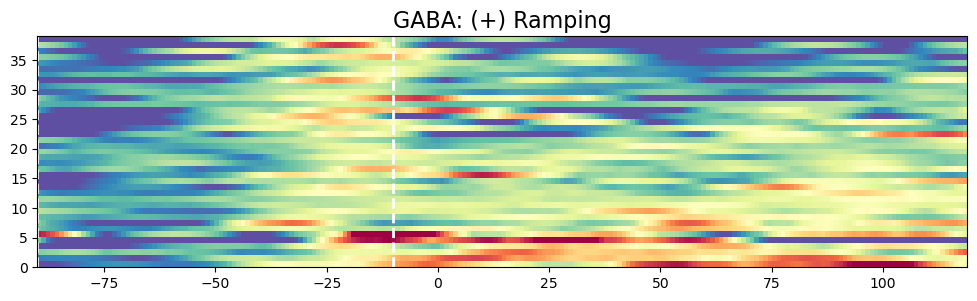

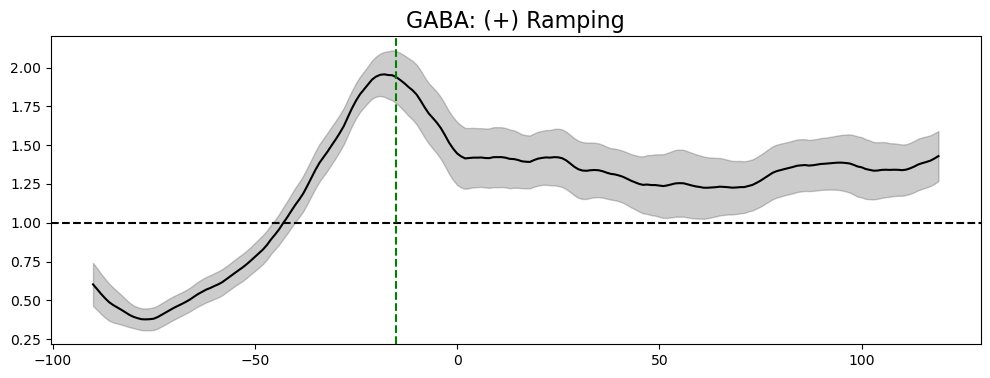

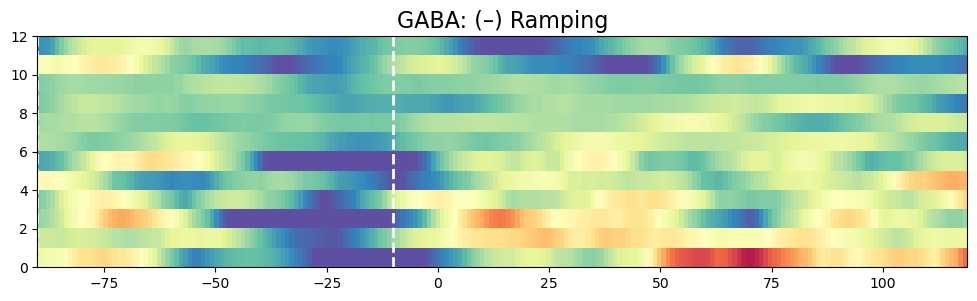

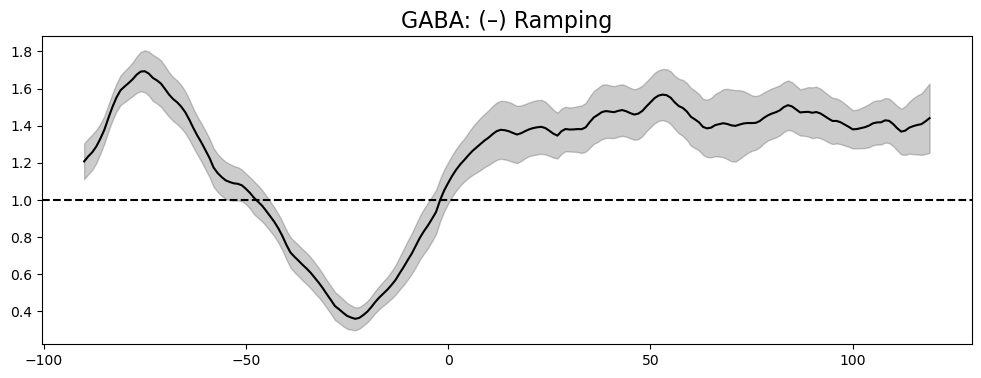

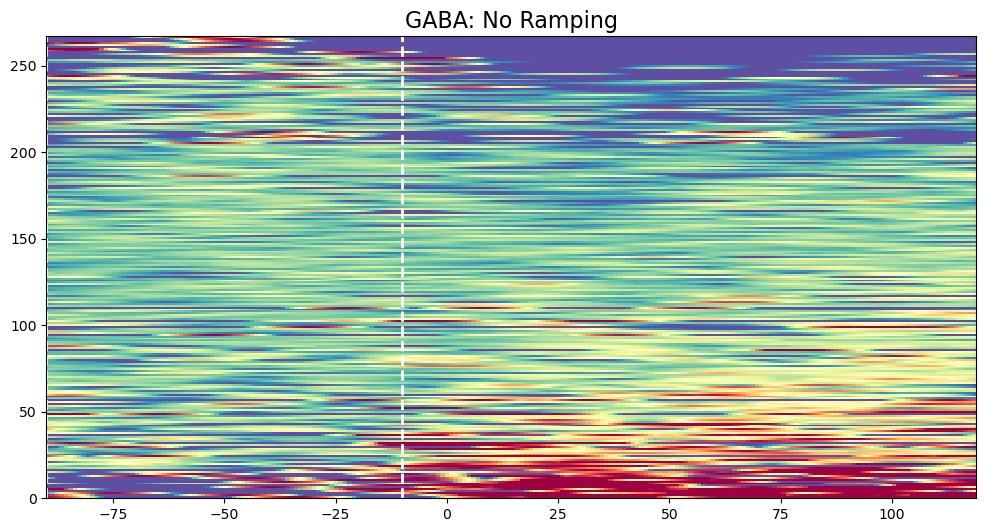

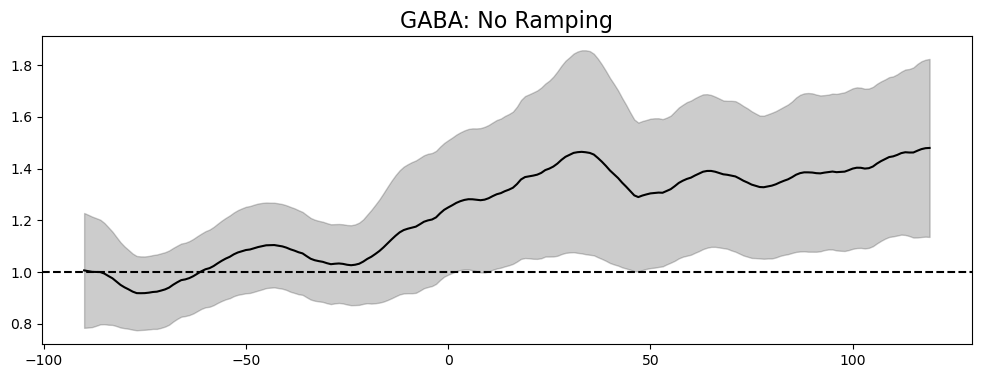

In [104]:
for experiment in experiments:
    
    events = experiment_events[experiment]
    df_ramp = experiment_ramp_effects[experiment]
    
    get_rates = lambda es: eval_rate( es, t_eval_rate,
                                      kernel = rate_kernel,
                                      baseline_window = ramp_window )
    
    rates_ramp_pos = np.array( [ get_rates( events[events[group_key] == group] )
                                 for group in df_ramp[df_ramp['+_ramping'] == True][group_key] ] )
    rates_ramp_neg = np.array( [ get_rates( events[events[group_key] == group] )
                                 for group in df_ramp[df_ramp['-_ramping'] == True][group_key] ] )
    rates_ramp_none = np.array( [ get_rates( events[events[group_key] == group] )
                                  for group in df_ramp[(df_ramp['+_ramping'] == False) & (df_ramp['-_ramping'] == False)][group_key] ] )
    
    # + Ramping
    
    raster_plot_usable( rates_ramp_pos, t_eval_rate,
                        baseline_window = ramp_window,
                        height = raster_height_small,
                        title = f'{experiment}: (+) Ramping' )
    
    trace_plot_usable( rates_ramp_pos, t_eval_rate,
                       kernel_width = rate_kernel_width,
                       baseline_window = ramp_window,
                       title = f'{experiment}: (+) Ramping' )
    
    # - Ramping
    
    raster_plot_usable( rates_ramp_neg, t_eval_rate,
                        baseline_window = ramp_window,
                        height = raster_height_small,
                        title = f'{experiment}: (–) Ramping' )
    
    trace_plot_usable( rates_ramp_neg, t_eval_rate,
                       baseline_window = ramp_window,
                       title = f'{experiment}: (–) Ramping' )
    
    # No ramping
    
    raster_plot_usable( rates_ramp_none, t_eval_rate,
                        baseline_window = ramp_window,
                        height = raster_height_large,
                        title = f'{experiment}: No Ramping' )
    
    trace_plot_usable( rates_ramp_none, t_eval_rate,
                       baseline_window = ramp_window,
                       title = f'{experiment}: No Ramping' )

---

## Export

In [105]:
for experiment in experiments:
    df_ramp = experiment_ramp_effects[experiment]
    save_csv( f'ramping-{experiment}', df_ramp )